In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from striplog import Striplog, Interval, Legend, Component, Decor
from striplog.striplog import StriplogError

from coremdlr.viz import CorePlotter
from coremdlr.datasets import WellLoader
from coremdlr.config.strip_config import facies as litho_facies 
from coremdlr.config.strip_config import legend as litho_legend

Using TensorFlow backend.


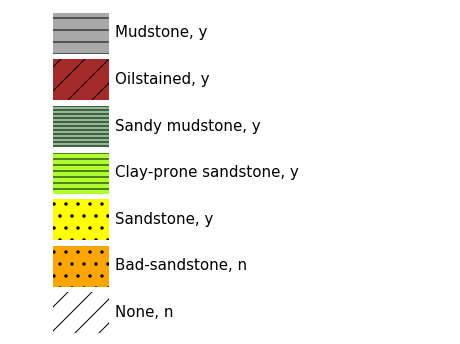

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

litho_legend.plot(ax=ax)

fig.savefig('litho_legend.pdf')

## Load Data

In [2]:
usecols = ['y_true', 'y_pred', 'confidence',
       'regression', 'proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4',
       'proba_5', 'proba_6', 'depth', 'top', 'base', 'Umean', 'Rmean', 'Gmean',
       'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'well', 'set_number']

facies_df = pd.read_csv('Facies_CCL_results_ADJ_FACIES.csv', usecols=usecols)
facies_df.head()

,y_true,y_pred,confidence,regression,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,...,Umean,Rmean,Gmean,Bmean,Uvar,Rvar,Gvar,Bvar,well,set_number
0,5,5,0.611914,8.179710,0.151625,0.602441,0.141148,0.331870,0.130421,0.304246,...,-0.169696,-0.037076,-0.185816,-0.451029,-0.262351,-0.237118,-0.263653,-0.321653,204-19-3A,0
1,5,5,0.615519,8.284686,0.155240,0.590467,0.152746,0.335375,0.144083,0.303014,...,-0.083072,0.069513,-0.101441,-0.404928,-0.242584,-0.238451,-0.243797,-0.256717,204-19-3A,0
2,5,1,0.641316,7.987141,0.161152,0.641316,0.158672,0.342645,0.154063,0.301181,...,-0.127903,0.021166,-0.146246,-0.438773,-0.078964,-0.015447,-0.084968,-0.198222,204-19-3A,0
3,5,1,0.634600,7.970081,0.150747,0.634600,0.135835,0.307645,0.126664,0.299217,...,-0.105186,0.053991,-0.124798,-0.435397,-0.288769,-0.278994,-0.289781,-0.317195,204-19-3A,0
4,5,5,0.633112,7.861452,0.112771,0.632838,0.113001,0.301848,0.105169,0.266508,...,-0.109990,0.053269,-0.130225,-0.446917,-0.290969,-0.288689,-0.291185,-0.308890,204-19-3A,0


In [3]:
facies_df.y_true.value_counts(), facies_df.y_pred.value_counts()

(0    10925
 5     7669
 1     7434
 4     4844
 2     1828
 3      834
 Name: y_true, dtype: int64, 0    14504
 1     9627
 5     8294
 4     1109
 Name: y_pred, dtype: int64)

In [4]:
litho_df = pd.read_csv('pgr_wavenet_results_train_sets9_FINAL.csv', index_col='Unnamed: 0')
litho_df.head()

,y_true,y_pred,confidence,regression,proba_0,proba_1,proba_2,proba_3,proba_4,depth,...,Umean,Rmean,Gmean,Bmean,Uvar,Rvar,Gvar,Bvar,well,set_number
0,1,3,0.960986,3.987930,0.045533,0.224746,0.119336,0.960986,0.098391,2401.034821,...,-0.870509,-0.882212,-0.862941,-0.786740,0.116607,0.227614,0.103433,-0.117270,204-20-3,0
1,1,3,0.973069,3.919785,0.039181,0.176123,0.110202,0.973069,0.091855,2401.040191,...,-0.715778,-0.704601,-0.712499,-0.682090,-0.194828,-0.175045,-0.197290,-0.254695,204-20-3,0
2,1,3,0.971063,3.969067,0.042374,0.177723,0.117010,0.971063,0.099823,2401.045561,...,-0.650777,-0.627985,-0.649280,-0.643503,-0.223588,-0.246934,-0.221730,-0.206153,204-20-3,0
3,1,3,0.969221,3.973616,0.044048,0.186133,0.119370,0.969221,0.098869,2401.050931,...,-0.621952,-0.600528,-0.619157,-0.628618,-0.264968,-0.276889,-0.265391,-0.249082,204-20-3,0
4,1,3,0.968116,4.049161,0.046571,0.177138,0.127770,0.968116,0.113485,2401.056301,...,-0.617996,-0.599731,-0.615214,-0.616868,-0.238730,-0.259822,-0.237936,-0.205585,204-20-3,0


In [5]:
litho_df.y_true.value_counts(), litho_df.y_pred.value_counts()

(0    34867
 4    32226
 3    17441
 1    15227
 2    11040
 Name: y_true, dtype: int64, 4    43349
 0    39993
 3    24660
 2     2116
 1      683
 Name: y_pred, dtype: int64)

## Striplog Stuff

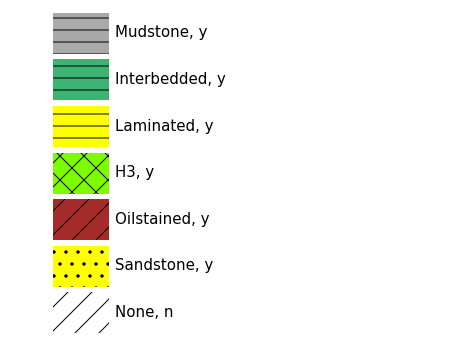

In [9]:
facies = {
    '0': Component({'lithology': 'none', 'train':'n'}),
    '1': Component({'lithology': 'sandstone', 'train':'y'}),
    '2': Component({'lithology': 'oilstained', 'train':'y'}),
    '3': Component({'lithology': 'H3', 'train':'y'}),
    '4': Component({'lithology': 'laminated', 'train':'y'}),
    '5': Component({'lithology': 'interbedded', 'train':'y'}),
    '6': Component({'lithology': 'mudstone', 'train':'y'})
}

###########################
### Visualization Style ###
###########################

nocore = Decor({
    'component': facies['0'],
    'colour': 'white',
    'hatch': '/',
    'width': '5',
})

sandstone = Decor({
    'component': facies['1'],
    'colour': 'yellow',
    'hatch': '.',
    'width': '4',
})

oilstained = Decor({
    'component': facies['2'],
    'colour': 'brown',
    'hatch': '/',
    'width': '3',
})

h3 = Decor({
    'component': facies['3'],
    'colour': 'lawngreen',
    'hatch': 'X',
    'width': '3',
})

lamsand = Decor({
    'component': facies['4'],
    'colour': 'yellow',
    'hatch': '-',
    'width': '3.5',
})

interbedded = Decor({
    'component': facies['5'],
    'colour': 'mediumseagreen',
    'hatch': '-',
    'width': '3.5',
})

mudstone = Decor({
    'component': facies['6'],
    'colour': 'darkgray',
    'hatch': '-',
    'width': '1',
})

facies_legend = Legend([nocore, sandstone, oilstained, h3, lamsand, interbedded, mudstone])


fig, ax = plt.subplots(figsize=(8,6))

facies_legend.plot(ax=ax)

fig.savefig('facies_legend.pdf')

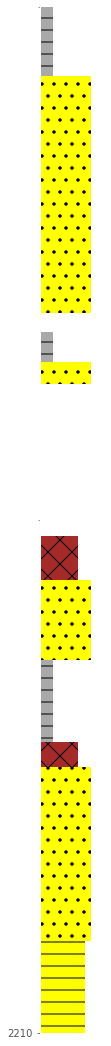

In [7]:

def df_to_faciestrip(df, top, base, labels_col, no_cores=[]):
    """
    Make and return striplog. Optionally save as csv to `save_csv`.
    If labels is None, uses uncollapsed self._y as labels.
    
    `no_cores` to specify no-core intervals
    """
    intervals = []
    facies_keys = list(facies.keys())
    
    # Slice between top and base
    df = df[(df.base > top) & (df.top < base)].sort_values('top')
    #print(df[['top', 'base', labels_col]])
    
    labels, tops, bases = df[labels_col].values, df.top.values, df.base.values
    tops[0], bases[-1] = top, base

    current_label = labels[0]
    current_top, current_base = tops[0], bases[0]

    for i in range(1, labels.size):
        if labels[i] == current_label or i == (labels.size-1):
            current_base = bases[i]
            
        if labels[i] != current_label or i == (labels.size-1):
            # close previous interval
            descrip = facies_keys[current_label+1]
            component = facies[descrip]
            #print(descrip, component, current_top, current_base)
            interval = Interval(top=current_top,
                                base=current_base,
                                description = descrip,
                                components = [component])
            intervals.append(interval)

            # open new interval
            current_label = labels[i]
            current_top, current_base = tops[i], bases[i]
            
    try:
        striplog = Striplog(intervals)
    except StriplogError as e:
        print(e)
        for iv in intervals:
            print(f'top: {iv.top}, base: {iv.base}, order: {iv.order}')

    return striplog



test_df = facies_df[(facies_df.set_number == 1) & (facies_df.well == '204-19-6')]

strip = df_to_faciestrip(test_df, 2208., 2210., 'y_true')
strip.plot(legend=facies_legend)

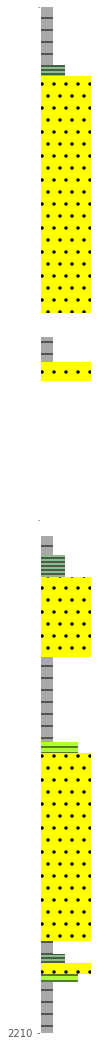

In [8]:
def df_to_lithostrip(df, top, base, labels_col, no_cores=[]):
    """
    Make and return striplog. Optionally save as csv to `save_csv`.
    If labels is None, uses uncollapsed self._y as labels.
    
    `no_cores` to specify no-core intervals
    """
    intervals = []
    facies_keys = list(litho_facies.keys())
    
    # Slice between top and base
    df = df[(df.base > top) & (df.top < base)]
    
    labels, tops, bases = df[labels_col].values, df.top.values, df.base.values
    tops[0], bases[-1] = top, base
    

    current_label = labels[0]
    current_top, current_base = tops[0], bases[0]

    for i in range(1, labels.size):
        #if (bases[i])
        
        if labels[i] == current_label or i == (labels.size-1):
            current_base = bases[i]
            
        if labels[i] != current_label or i == (labels.size-1):
            # close previous interval
            descrip = facies_keys[current_label+2]
            component = litho_facies[descrip]
            #print(descrip, type(component))
            interval = Interval(top=current_top,
                                base=current_base,
                                description = descrip,
                                components = [component])
            intervals.append(interval)

            # open new interval
            current_label = labels[i]
            current_top, current_base = tops[i], bases[i]
            
    try:
        striplog = Striplog(intervals)
    except StriplogError as e:
        print(e)
        for iv in intervals:
            print(f'top: {iv.top}, base: {iv.base}, order: {iv.order}')

    return striplog


strip = df_to_lithostrip(litho_df, 2208., 2210., 'y_true')
strip.plot(legend=litho_legend)

## Striplogs

In [ ]:
# Facies
fdf = facies_df[facies_df.set_number == 1]

facies_ytrue_stripA = df_to_faciestrip(fdf, 2208., 2210., 'y_true')
facies_ypred_stripA = df_to_faciestrip(fdf, 2208., 2210., 'y_pred')

facies_ytrue_stripB = df_to_faciestrip(fdf, 2214., 2216., 'y_true')
facies_ypred_stripB = df_to_faciestrip(fdf, 2214., 2216., 'y_pred')

fdf.y_pred.value_counts(), fdf.y_true.value_counts()

In [ ]:
fdf

In [ ]:
# Litho
ldf = litho_df[litho_df.set_number == 1]

litho_ytrue_stripA = df_to_lithostrip(ldf, 2208., 2210., 'y_true')
litho_ypred_stripA = df_to_lithostrip(ldf, 2208., 2210., 'y_pred')

litho_ytrue_stripB = df_to_lithostrip(ldf, 2214., 2216., 'y_true')
litho_ypred_stripB = df_to_lithostrip(ldf, 2214., 2216., 'y_pred')

ldf.y_pred.value_counts(), ldf.y_true.value_counts()

## The Rest

In [ ]:
litho_facies.keys()

In [12]:
well_litho = WellLoader('204-19-6', use_pseudoGR=True,
                  pseudoGR_args={'features': ['mean', 'var'], 'per_channel' : True})

labels = np.array(list(litho_facies.keys()), dtype='a2').tolist()

well_litho.load_data(labels, skip=2)

Loading Well:  204-19-6  from  /home/ross/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']
Feature shapes:  [('depth', (1947,)), ('top', (1947,)), ('base', (1947,)), ('image', (1947, 32, 600, 3)), ('pseudoGR', (1947, 32, 8))]


In [13]:
well_facies = WellLoader('204-19-6', use_pseudoGR=True, labels_ext='_labelsII.npy',
                  pseudoGR_args={'features': ['mean', 'var'], 'per_channel' : True})

labels = np.array(list(facies.keys()), dtype='a2').tolist()

well_facies.load_data(labels, skip=1)

Loading Well:  204-19-6  from  /home/ross/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


ValueError: b'7' is not in list

In [ ]:
well._image.shape, well._pseudoGR.shape, well._depth.shape, well.pGR_feat_names

In [ ]:
pGR_feat2idx = {feat_name : i for feat_name, i in zip(well.pGR_feat_names, range(8))}
pGR_feat2idx

In [ ]:
# 2214.2 to 2214.8
def slice_well(well, top, base):
    ds = well._depth
    good_idxs = np.logical_and(ds >= top, ds <= base)
    
    return {'image' : well._image[good_idxs],
            'pGR' :  well._pseudoGR[good_idxs],
            'depth' : well._depth[good_idxs]}

Xa = slice_well(well, 2208., 2210.01)

Xb = slice_well(well, 2214., 2216.01)

In [ ]:
coreplotter = CorePlotter(figsize=(15, 15))

coreplotter.plot_image(Xa['image'] / 255.0, Xa['depth'], major_tick_size=22)
img_ax = coreplotter.get_ax_by_name('Image')

#img_ax.set_title('Image', fontsize=24)
img_ax.set_yticklabels([], minor=True)
img_ax.set_xticks([])
img_ax.set_xticklabels([])

# plot RGB
r = Xa['pGR'][:, pGR_feat2idx['Rmean']]
g = Xa['pGR'][:, pGR_feat2idx['Gmean']]
b = Xa['pGR'][:, pGR_feat2idx['Bmean']]
u = (r + g + b) / 3.

xlim = (0., 1.)#np.nanmin(np.concatenate([r,g,b])), np.nanmax(np.concatenate([r,g,b]))
coreplotter.plot_log(Xa['depth'], u, c='k', name='RGB', lw=2, alpha=1.0, xlim=xlim)
coreplotter.plot_log(Xa['depth'], r, c='r', name='RGB', lw=2, alpha=0.9, xlim=xlim)
coreplotter.plot_log(Xa['depth'], g, name='RGB', c='g', lw=2, alpha=0.8, xlim=xlim)
coreplotter.plot_log(Xa['depth'], b, name='RGB', c='b', lw=2, alpha=0.7, xlim=xlim)

log_ax = coreplotter.get_ax_by_name('RGB')
#log_ax.set_title('RGB Logs', fontsize=24)
log_ax.set_yticks([])
log_ax.tick_params(axis='x', colors='black', labelsize=16)


coreplotter.plot_strip(well_litho.make_striplog(, name='Labels', legend=litho_legend)
coreplotter.get_ax_by_name('Labels').set_title('Labels', fontsize=24)

coreplotter.plot_strip(litho_ypred_stripA, name='Preds', legend=litho_legend)
coreplotter.get_ax_by_name('Preds').set_title('Preds', fontsize=24)

#coreplotter.plot_strip(facies_ytrue_stripA, name='Facies Labels', legend=facies_legend)
#coreplotter.get_ax_by_name('Facies Labels').set_title('Facies Labels', fontsize=24)

#coreplotter.plot_strip(facies_ypred_stripA, name='Facies Preds', legend=facies_legend)
#coreplotter.get_ax_by_name('Facies Preds').set_title('Facies Preds', fontsize=24)

#coreplotter.fig.show()
#coreplotter.fig.savefig('figure6_large.svg', bbox_inches="tight")

In [ ]:
coreplotter = CorePlotter(figsize=(15, 15))

coreplotter.plot_image(Xb['image'] / 255.0, Xb['depth'], major_tick_size=22)
img_ax = coreplotter.get_ax_by_name('Image')

#img_ax.set_title('Image', fontsize=24)
img_ax.set_yticklabels([], minor=True)
img_ax.set_xticks([])
img_ax.set_xticklabels([])

# plot RGB
r = Xb['pGR'][:, pGR_feat2idx['Rmean']]
g = Xb['pGR'][:, pGR_feat2idx['Gmean']]
b = Xb['pGR'][:, pGR_feat2idx['Bmean']]
u = (r + g + b) / 3.

xlim = (0., 1.)#np.nanmin(np.concatenate([r,g,b])), np.nanmax(np.concatenate([r,g,b]))
coreplotter.plot_log(Xb['depth'], u, c='k', name='RGB', lw=2, alpha=1.0, xlim=xlim)
coreplotter.plot_log(Xb['depth'], r, c='r', name='RGB', lw=2, alpha=0.9, xlim=xlim)
coreplotter.plot_log(Xb['depth'], g, name='RGB', c='g', lw=2, alpha=0.8, xlim=xlim)
coreplotter.plot_log(Xb['depth'], b, name='RGB', c='b', lw=2, alpha=0.7, xlim=xlim)

log_ax = coreplotter.get_ax_by_name('RGB')
#log_ax.set_title('RGB Logs', fontsize=24)
log_ax.set_yticks([])
log_ax.tick_params(axis='x', colors='black', labelsize=16)


coreplotter.plot_strip(litho_ytrue_stripB, name='Labels')
coreplotter.get_ax_by_name('Labels').set_title('Labels', fontsize=24)

coreplotter.plot_strip(litho_ypred_stripB, name='Preds')
coreplotter.get_ax_by_name('Preds').set_title('Preds', fontsize=24)

coreplotter.plot_strip(facies_ytrue_stripB, name='Facies Labels', legend=facies_legend)
coreplotter.get_ax_by_name('Facies Labels').set_title('Facies Labels', fontsize=24)

coreplotter.plot_strip(facies_ypred_stripB, name='Facies Preds', legend=facies_legend)
coreplotter.get_ax_by_name('Facies Preds').set_title('Facies Preds', fontsize=24)

In [ ]:
Xa

In [ ]:
pGR_feat2idx = {feat_name : i for feat_name, i in zip(well.pGR_feat_names, range(8))}
pGR_feat2idx

In [ ]:
well.logs_df[~well.logs_df.isna().any(axis=1)]

In [ ]:
coreplotter = CorePlotter(figsize=(40,600))

# plot image
coreplotter.plot_image(well._image / 255.0, well._depth)
coreplotter.get_ax_by_name('Image').set_title('Image', fontsize=24)

# plot RGB
r = well._pseudoGR[:, pGR_feat2idx['Rmean']]
g = well._pseudoGR[:, pGR_feat2idx['Gmean']]
b = well._pseudoGR[:, pGR_feat2idx['Bmean']]

xlim = np.nanmin(np.concatenate([r,g,b])), np.nanmax(np.concatenate([r,g,b]))
coreplotter.plot_log(well._depth, r, c='r', name='RGB', lw=3, alpha=0.9, xlim=xlim)
coreplotter.plot_log(well._depth, g, name='RGB', c='g', lw=3, alpha=0.7, xlim=xlim)
coreplotter.plot_log(well._depth, b, name='RGB', c='b', lw=3, alpha=0.5, xlim=xlim)

log_ax = coreplotter.get_ax_by_name('RGB')
log_ax.set_title('RGB Logs', fontsize=24)
log_ax.set_yticks([])
log_ax.set_xticklabels([])


# plot logs
logs_df = well.logs_df[~well.logs_df.isna().any(axis=1)]

# PEF
coreplotter.plot_log(logs_df.index.values, logs_df.PEF.values, name='PEF', c='g', xlim=(0,10))
log_ax = coreplotter.get_ax_by_name('PEF')
log_ax.set_title('PEF', fontsize=24)
log_ax.set_yticks([])

# GR
coreplotter.plot_log(logs_df.index.values, logs_df.GR.values, name='GR', c='b', xlim=(0,150))
log_ax = coreplotter.get_ax_by_name('GR')
log_ax.set_title('GR', fontsize=24)
log_ax.set_yticks([])

# Predicted labels
y_pred = results.y_pred.values
y_pred[np.where(y_pred==3)] = 4    # have to change 3->4 because of new labels ('os'->'sh')
coreplotter.plot_strip(well.make_striplog(labels=y_pred), name='Preds')
coreplotter.get_ax_by_name('Preds').set_title('Preds', fontsize=24)

# Confidence
coreplotter.plot_log(results.depth.values, results.confidence.values, name='Conf', color='black', xlim=(0.6,1))
log_ax = coreplotter.get_ax_by_name('Conf')
log_ax.set_title('Confidence', fontsize=24)
log_ax.set_yticks([])

# true labels
coreplotter.plot_strip(well.make_striplog(), name='Labels')
coreplotter.get_ax_by_name('Labels').set_title('Labels', fontsize=24)

#coreplotter.fig.show()
coreplotter.fig.savefig('wavenet_preds_RGB_logs_conf_204-19-6.png')

In [ ]:
coreplotter = CorePlotter(figsize=(15,600))

# plot image
coreplotter.plot_image(well._image / 255.0, well._depth)
coreplotter.get_ax_by_name('Image').set_title('Image', fontsize=24)

# true labels
coreplotter.plot_strip(well.make_striplog(), name='Labels')
coreplotter.get_ax_by_name('Labels').set_title('Labels', fontsize=24)

#coreplotter.fig.show()
coreplotter.fig.savefig('core_with_labels_204-19-6.png')

In [ ]:
results.y_pred.unique(), results.y_true.unique()

In [ ]:
coreplotter.fig.savefig('wavenet_preds_RGB_normed.png')

In [ ]:
d = {'a' : 0}
d.get('b')

In [ ]:
d.pop('b', 5)

In [ ]:
from coremdlr.viz.model_plots import confusion_matrix_plot

classes = ['sandstone', 'clay-prone sandstone', 'sandy mudstone', 'mudstone']

ax = confusion_matrix_plot({'y_pred' : y_pred, 'y_true' : results.y_true}, classes=classes)

In [ ]:
results.confidence.min()

In [ ]:
for name, grp in wavenet_results.groupby('well_name'):

    acc = (grp.y_true == grp.y_pred).sum() / grp.shape[0]
    print(name, np.round(acc, 3))

In [ ]:
results = wavenet_results[wavenet_results.well_name == '204-20-6a']

(results.y_true == results.y_pred).sum() / results.shape[0]

In [ ]:
results.y_pred.unique()

In [ ]:
well = WellLoader('204-20-6a', use_pseudoGR=True, use_logs=True,
                  pseudoGR_args={'features': ['mean'], 'per_channel' : True},
                  logs_args={'which_logs' : ['PEF', 'GR']})

labels = np.array(list(lithologies_dict.keys()), dtype='a2').tolist()

well.load_data(labels)

In [ ]:
coreplotter = CorePlotter(figsize=(40,600))

# plot image
coreplotter.plot_image(well._image / 255.0, well._depth)
coreplotter.get_ax_by_name('Image').set_title('Image', fontsize=24)

# plot RGB
r = well._pseudoGR[:, pGR_feat2idx['Rmean']]
g = well._pseudoGR[:, pGR_feat2idx['Gmean']]
b = well._pseudoGR[:, pGR_feat2idx['Bmean']]

xlim = np.nanmin(np.concatenate([r,g,b])), np.nanmax(np.concatenate([r,g,b]))
coreplotter.plot_log(well._depth, r, c='r', name='RGB', lw=3, alpha=0.9, xlim=xlim)
coreplotter.plot_log(well._depth, g, name='RGB', c='g', lw=3, alpha=0.7, xlim=xlim)
coreplotter.plot_log(well._depth, b, name='RGB', c='b', lw=3, alpha=0.5, xlim=xlim)

log_ax = coreplotter.get_ax_by_name('RGB')
log_ax.set_title('RGB Logs', fontsize=24)
log_ax.set_yticks([])
log_ax.set_xticklabels([])

# plot logs
logs_df = well.logs_df[~well.logs_df.isna().any(axis=1)]

# PEF
coreplotter.plot_log(logs_df.index.values, logs_df.PEF.values, name='PEF', c='g', xlim=(0,10))
log_ax = coreplotter.get_ax_by_name('PEF')
log_ax.set_title('PEF', fontsize=24)
log_ax.set_yticks([])

# GR
coreplotter.plot_log(logs_df.index.values, logs_df.GR.values, name='GR', c='b', xlim=(0,150))
log_ax = coreplotter.get_ax_by_name('GR')
log_ax.set_title('GR', fontsize=24)
log_ax.set_yticks([])

# Predicted labels
#y_pred = results.y_pred.values
#y_pred[np.where(y_pred==3)] = 4    # have to change 3->4 because of new labels ('os'->'sh')
#coreplotter.plot_strip(well.make_striplog(labels=y_pred), name='Preds')
#coreplotter.get_ax_by_name('Preds').set_title('Preds', fontsize=24)

# Confidence
coreplotter.plot_log(results.depth.values, results.confidence.values, name='Conf', color='black', xlim=(0.6,1))
log_ax = coreplotter.get_ax_by_name('Conf')
log_ax.set_title('Confidence', fontsize=24)
log_ax.set_yticks([])

# true labels
coreplotter.plot_strip(well.make_striplog(), name='Labels')
coreplotter.get_ax_by_name('Labels').set_title('Labels', fontsize=24)

coreplotter.fig.show()
#coreplotter.fig.savefig('wavenet_preds_RGB_logs_conf_204-20-6a.png')